In [150]:
import numpy as np
from sklearn.decomposition import PCA
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from mne import events_from_annotations
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score
# Assuming CSP is imported from its respective library
from mne.decoding import CSP  # This is just an example; adjust import as necessary
from sklearn.pipeline import Pipeline

TASK_1 = [1, 5, 9]
TASK_2 = [4, 8, 12]
TASK_3 = [5, 9, 13]
TASK_4 = [6, 10, 14]

SUBJECT = 1


In [151]:
import mne

# Define the path to your dataset
data_path = 'data/physionet.org/files/eegmmidb/1.0.0/'
subject = 'S001'
file_name = 'S001R06.edf'  # Example file name, adjust based on the specific file you want to load


full_file_path = f'{data_path}{subject}/{file_name}'
raw_baseline = mne.io.read_raw_edf(f'{data_path}{subject}/S001R01.edf', preload=True)
raw = mne.io.read_raw_edf(full_file_path, preload=True)
print(raw.info)

Extracting EDF parameters from /home/jolivier/Documents/42Lausanne/specialisation/total_perspective_vortex/data/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Extracting EDF parameters from /home/jolivier/Documents/42Lausanne/specialisation/total_perspective_vortex/data/physionet.org/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


In [152]:

def extract_events(raw):
	events, event_id = mne.events_from_annotations(raw)
	return events[:, 0], events[:, 2], event_id

def calculate_xmax(times, sfreq):
	time_diff = np.diff(times) / sfreq
	print(f"X_max: {np.max(time_diff)}")
	return np.max(time_diff)

# Rest of the code
times, event_type, event_id = extract_events(raw)
print(f"Times: {times},\n Event type: {event_type},\n Event id: {event_id}")

x_min = -0.5
x_max = calculate_xmax(times, raw.info['sfreq'])

Used Annotations descriptions: ['T0', 'T1', 'T2']
Times: [    0   672  1328  2000  2656  3328  3984  4656  5312  5984  6640  7312
  7968  8640  9296  9968 10624 11296 11952 12624 13280 13952 14608 15280
 15936 16608 17264 17936 18592 19264],
 Event type: [1 3 1 2 1 2 1 3 1 2 1 3 1 3 1 2 1 2 1 3 1 3 1 2 1 2 1 3 1 3],
 Event id: {'T0': 1, 'T1': 2, 'T2': 3}
X_max: 4.2


In [153]:
tmin = -0.5
tmax = 4.5

raw = mne.io.read_raw_edf(full_file_path, preload=True)
events, _ = mne.events_from_annotations(raw)
epochs = mne.Epochs(raw, events, dict(T0=1, T1=2, T2=3), tmin, tmax, proj=True, baseline=None, preload=True)


raw_baseline = mne.io.read_raw_edf(f'{data_path}{subject}/S001R01.edf', preload=True)
events_baseline = mne.make_fixed_length_events(raw_baseline, id=1, start=0, stop=None, duration=2)
epochs_baseline = mne.Epochs(raw_baseline, events_baseline, dict(T0=1), tmin=tmin, tmax=tmax, baseline=None, preload=True)

Extracting EDF parameters from /home/jolivier/Documents/42Lausanne/specialisation/total_perspective_vortex/data/physionet.org/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 801 original time points ...
1 bad epochs dropped
Extracting EDF parameters from /home/jolivier/Documents/42Lausanne/specialisation/total_perspective_vortex/data/physionet.org/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw

In [154]:
#merge the baseline and the main data
epochs = mne.concatenate_epochs([epochs, epochs_baseline])
epochs = epochs.apply_baseline((None, 0)) # apply a baseline (normalize the data)

Not setting metadata
57 matching events found
No baseline correction applied
Applying baseline correction (mode: mean)


/tmp/ipykernel_139111/2629041331.py:2: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  epochs = mne.concatenate_epochs([epochs, epochs_baseline])


In [164]:
epochs

#filter epoch and keep only T1 and T2
epochs = epochs['T1', 'T2']
epochs

Number of events,15
Events,T1: 7T2: 8
Time range,-0.500 – 4.500 s
Baseline,-0.500 – 0.000 s


In [165]:
labels = epochs.events[:, -1]  # Extracting labels from the epochs

# Initialize components
csp_transformer = CSP(n_components=8, reg=None, log=True, norm_trace=False)
clf = LogisticRegression(random_state=42)

# # Create a pipeline with the custom CSP transformer
pipe = Pipeline([('CSP', csp_transformer), ('LogisticRegression', clf)]) # Add the scaler here if necessary

# # Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Perform cross-validation
scores = cross_val_score(pipe, epochs.get_data(copy=True), labels, cv=cv, n_jobs=1) # Set n_jobs to 1 to avoid multithreading if you encounter problems

Computing rank from data with rank=None


    Using tolerance 0.00071 (2.2e-16 eps * 64 dim * 5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00034 (2.2e-16 eps * 64 dim * 2.4e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00071 (2.2e-16 eps * 64 dim * 5e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00038 (2.2e-16 eps * 64 dim * 2.7e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 6

In [166]:
scores

array([0.        , 0.33333333, 0.66666667, 0.33333333, 0.66666667])

In [19]:
#shape of data
print(epochs.get_data().shape)

(29, 64, 257)


/tmp/ipykernel_139111/1410900900.py:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  print(epochs.get_data().shape)


In [23]:
#check type of data
data.dtype

dtype('float64')

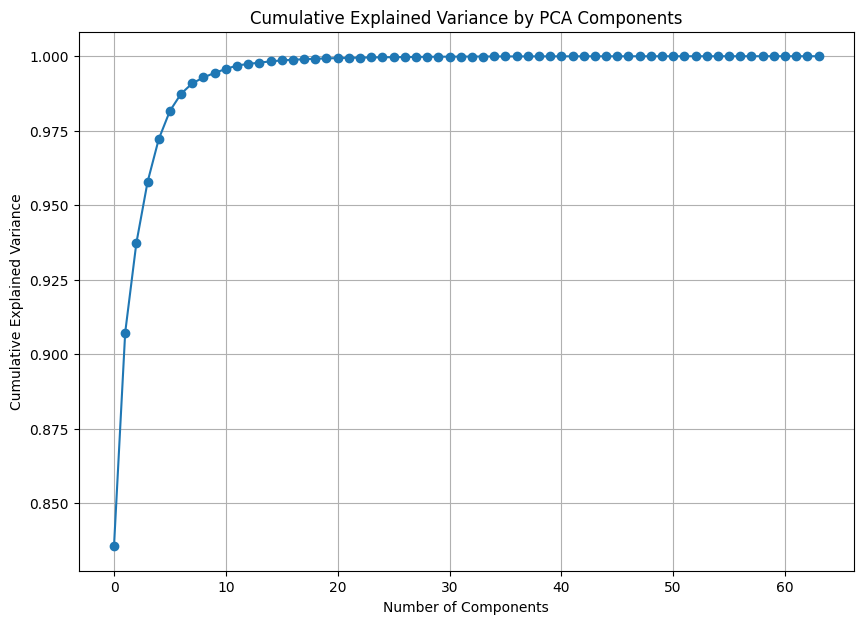

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(psds)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting the cumulative explained variance to decide on the number of components
plt.figure(figsize=(10, 7))
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


Used Annotations descriptions: ['T0']


(array([[0, 0, 1]]), {'T0': 1})